# Poetry generator with Shakespeare sonnets

* Machine learned poetry generator using Shakespeare sonnets.
* Current sentences as inputs, and next word as labels.
* Word embedding and (bidirectional) LSTM.
* Dropout and L2 regularization for avoiding overfitting.

## Download Shakespeare sonnetx

In [2]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [3]:
tf.enable_eager_execution()

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")
corpus = corpus[:int(len(corpus)/2)]
print("First 3 sentences:")
print(corpus[0])
print(corpus[1])
print(corpus[2])

--2019-08-04 14:21:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4009:806::2010, 172.217.4.208
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4009:806::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.03s   

2019-08-04 14:21:57 (2.59 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]

First 3 sentences:
from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,


## Tokenizing the dataset

* Pre-padding setences, such that the last word is the label for the sentence before.
* One-hot encoding the labels => It would be memory intense for large data set. In this case, character based model can be used instead.

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow.keras.utils as ku 

# Tokenizing using the Shakespeare corpus
tokenizer.fit_on_texts(corpus)

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pre-pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
print("Maximum length of a sentence = ", max_sequence_len)
input_sequences_padded = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create sentences and labels
sentences, labels = input_sequences_padded[:,:-1], input_sequences_padded[:,-1]

# One-hot encoding
total_words = len(tokenizer.word_index) + 1 # Including oov
labels = ku.to_categorical(labels, num_classes=total_words)

Maximum length of a sentence =  11


## Building the NLP model

# Two LSTM layers
* Dropout and L2 regularization used for avoiding overfitting.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(100, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
#adam = Adam(lr=0.01) # detault lr = 0.001
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 100)           208900    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 200)           160800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_6 (Dense)              (None, 1044)              105444    
_________________________________________________________________
dense_7 (Dense)              (None, 2089)              2183005   
Total params: 2,778,549
Trainable params: 2,778,549
Non-trainable params: 0
____________________________________________

* Traning

In [14]:
num_epochs = 100
history = model.fit(sentences, labels, epochs=num_epochs)

Epoch 1/100
7681/7681 [==============================] - 24s 3ms/sample - loss: 7.0152 - acc: 0.0225

* Plotting traning history
* With 100 epochs, the accuracy on training data can be up to ~ 0.8.

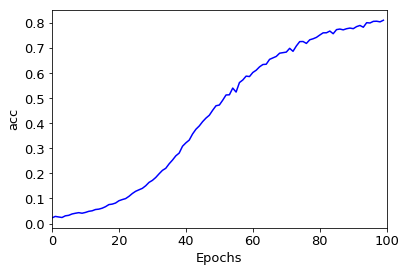

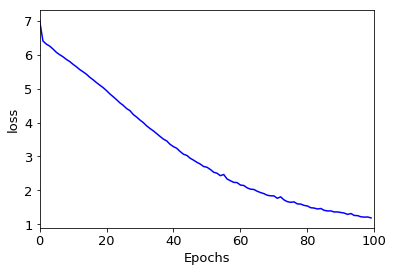

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    font = 13
    plt.plot(history.history[string],'b')
    plt.xlabel("Epochs", fontsize=font)
    plt.ylabel(string, fontsize=font)
    plt.xlim([0,num_epochs])
    #plt.ylim([-0.1,1.1])
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.show()

plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Generating machine learned poem

* Use the trained LSTM model, generate a poem from a seed text.
* As the setence goes long, there appears some repeated words, such as "indeed indeed indeed indeed" and "done done done done done". This is because the prediction of the next word is based on the probability that each word matches the given sentnece. This probability gradually goes down as there are more words created.

In [17]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my love i hast thy due of heart that thou usest bear thee viewest rehearse open ordering fire shall seen quite kind influence aside rehearse boundless born gems contains decays new worth from mine eye before doth west with this disgrace with nature's first gone know show your shade shines so women's youth decay decay new kind hearted prove one prove false but one date worth to women's make one lively quality lover prove false ' ' prove false hours like none indeed indeed indeed indeed done done done done done had brought done twain know show thee show me
